# Simple Model Build Example
### Part II -- Next up Simple Model Deploy on K8s
2022 June 1

### The Job is to predict level adult earnings per year

Data we have available has incomes above or below $50K based on deomographics 

![alt text](../img/model_grid.png "Model Grid")

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from model.training_data import *

%matplotlib inline

In [2]:
print(file_path)
!ls $file_path

../data/
adult.data   decision_tree.pkl	neural_net_scaler.pkl
adult.names  neural_net.pkl


In [3]:
header = get_header()
print("\n".join(header))

age
workclass
fnlwgt
education
education-num
marital-status
occupation
relationship
race
sex
capital-gain
capital-loss
hours-per-week
native-country
class


In [4]:
df = get_training_dataframe()
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Explore the Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
for h in header:
    n = len(df[h].value_counts())
    if n < 20:
        print("##################################")
        print(f"{h}: {n}")
        print(df[h].value_counts())

##################################
workclass: 9
 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64
##################################
education: 16
 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64
##################################
education-num: 16
9     15784
10    10878
13     8025
14     2657
11     2061
7      1812
12     1601
6      1389
4       955
15      834
5       756
8       657
16      594
3       509
2       247

### Encoding classes will help a classifiers include all the inforamtion available
Start with an easy one...Sex in this data set has only 2 values.

In [8]:
# input encodings
df["sex-val"] = df["sex"].apply(lambda x: 1 if "M" in x else 0)
df[["sex", "sex-val"]].head(10)

,sex,sex-val
0,Male,1
1,Male,1
2,Male,1
3,Male,1
4,Female,0
5,Female,0
6,Female,0
7,Male,1
8,Female,0
9,Male,1


### Start modeling with a simple case -- only encoded or continuous data

In [9]:
dft = df[['age','fnlwgt','sex-val','education-num', "capital-gain", "capital-loss", "hours-per-week"]].copy()
y = df["class"]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree

### Testing and Training sets help us evaluate performance

![alt text](../img/test_train_split.png "Test Train Split")


In [11]:
X_train, X_test, y_train, y_test = train_test_split(dft, y)

In [12]:
dec_tree=DecisionTreeClassifier().fit(X_train, y_train)
a = dec_tree.score(X_test, y_test)
print('Accuracy is: %', a*100)

Accuracy is: % 78.19179428384244


In [13]:
y_preds = dec_tree.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.86      9358
        >50K       0.53      0.56      0.54      2853

    accuracy                           0.78     12211
   macro avg       0.70      0.70      0.70     12211
weighted avg       0.79      0.78      0.78     12211



### Let's look at the decision tree...

High dimensionality, so maybe too complex to be explanatory? Also, maybe generate some skepticism on how will it will generalize?

In [14]:
text_representation = tree.export_text(dec_tree)
print(text_representation)

|--- feature_4 <= 5119.00
|   |--- feature_3 <= 12.50
|   |   |--- feature_0 <= 30.50
|   |   |   |--- feature_0 <= 25.50
|   |   |   |   |--- feature_5 <= 2600.50
|   |   |   |   |   |--- feature_0 <= 23.50
|   |   |   |   |   |   |--- feature_5 <= 1824.50
|   |   |   |   |   |   |   |--- feature_6 <= 45.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 21.50
|   |   |   |   |   |   |   |   |   |--- feature_6 <= 42.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 324751.00
|   |   |   |   |   |   |   |   |   |   |   |--- class:  <=50K
|   |   |   |   |   |   |   |   |   |   |--- feature_1 >  324751.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_6 >  42.50
|   |   |   |   |   |   |   |   |   |   |--- feature_6 <= 43.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_6 >  43.50
|   |   |   |   |   |   |   |   |

### Does it help to normalize continuous values?

In [15]:
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
test_dec_tree=DecisionTreeClassifier().fit(X_train, y_train)

In [17]:
a = test_dec_tree.score(X_test, y_test)
print('Accuracy is: %', a*100)

Accuracy is: % 78.11809024649907


In [18]:
y_preds = test_dec_tree.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.86      9358
        >50K       0.53      0.55      0.54      2853

    accuracy                           0.78     12211
   macro avg       0.70      0.70      0.70     12211
weighted avg       0.78      0.78      0.78     12211



## Try Deep Learning Model

Requires "1-hot" class incoding

In [19]:
# output encodings
df["gt50k"] = df["class"].apply(lambda x: 1 if ">" in x else 0)
df["lte50k"] = df["class"].apply(lambda x: 1 if "<=" in x else 0)
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,sex-val,gt50k,lte50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,1,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,1,0,1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,1,0,1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,1,0,1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,0,1
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0,0,1
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0,0,1
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1,1,0
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,0,1,0
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1,1,0


In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [21]:
# Testing/Training Split
dy = df[["gt50k", "lte50k"]]
X_train, X_test, y_train, y_test = train_test_split(dft, dy)

In [22]:
#Normalizing the data
nnsc = StandardScaler()
X_train = nnsc.fit_transform(X_train)
X_test = nnsc.transform(X_test)

In [23]:
# Neural network
model = Sequential()
model.add(Dense(20, input_dim=7, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                336       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 530
Trainable params: 530
Non-trainable params: 0
_________________________________________________________________
None


2022-06-01 17:59:18.778748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 17:59:18.800779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-06-01 17:59:18.800791: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-01 17:59:18.801166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
573/573 [==============================] - 1s 932us/step - loss: 0.4493 - accuracy: 0.7826 - val_loss: 0.3886 - val_accuracy: 0.8207
Epoch 2/100
573/573 [==============================] - 0s 734us/step - loss: 0.3765 - accuracy: 0.8297 - val_loss: 0.3794 - val_accuracy: 0.8243
Epoch 3/100
573/573 [==============================] - 0s 729us/step - loss: 0.3717 - accuracy: 0.8311 - val_loss: 0.3773 - val_accuracy: 0.8252
Epoch 4/100
573/573 [==============================] - 0s 719us/step - loss: 0.3698 - accuracy: 0.8311 - val_loss: 0.3771 - val_accuracy: 0.8252
Epoch 5/100
573/573 [==============================] - 0s 733us/step - loss: 0.3688 - accuracy: 0.8317 - val_loss: 0.3753 - val_accuracy: 0.8274
Epoch 6/100
573/573 [==============================] - 0s 732us/step - loss: 0.3678 - accuracy: 0.8322 - val_loss: 0.3761 - val_accuracy: 0.8257
Epoch 7/100
573/573 [==============================] - 0s 722us/step - loss: 0.3673 - accuracy: 0.8323 - val_loss: 0.3745 - val_ac

573/573 [==============================] - 0s 718us/step - loss: 0.3564 - accuracy: 0.8374 - val_loss: 0.3680 - val_accuracy: 0.8286
Epoch 58/100
573/573 [==============================] - 0s 719us/step - loss: 0.3559 - accuracy: 0.8376 - val_loss: 0.3689 - val_accuracy: 0.8285
Epoch 59/100
573/573 [==============================] - 0s 729us/step - loss: 0.3559 - accuracy: 0.8377 - val_loss: 0.3682 - val_accuracy: 0.8296
Epoch 60/100
573/573 [==============================] - 0s 742us/step - loss: 0.3557 - accuracy: 0.8373 - val_loss: 0.3688 - val_accuracy: 0.8280
Epoch 61/100
573/573 [==============================] - 0s 735us/step - loss: 0.3555 - accuracy: 0.8382 - val_loss: 0.3708 - val_accuracy: 0.8282
Epoch 62/100
573/573 [==============================] - 0s 715us/step - loss: 0.3556 - accuracy: 0.8384 - val_loss: 0.3680 - val_accuracy: 0.8283
Epoch 63/100
573/573 [==============================] - 0s 731us/step - loss: 0.3554 - accuracy: 0.8377 - val_loss: 0.3682 - val_accuracy

In [26]:
y_pred = model.predict(X_test)

382/382 [==============================] - 0s 418us/step


In [27]:
#Converting 1-hot predictions to class label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

In [28]:
# Because 1-hot is (0,1), this is also class label index
test = list(y_test.lte50k)

In [29]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is: %', a*100)

Accuracy is: % 83.01531406109245


In [30]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.72      0.49      0.58      2941
           1       0.85      0.94      0.89      9270

    accuracy                           0.83     12211
   macro avg       0.78      0.71      0.74     12211
weighted avg       0.82      0.83      0.82     12211



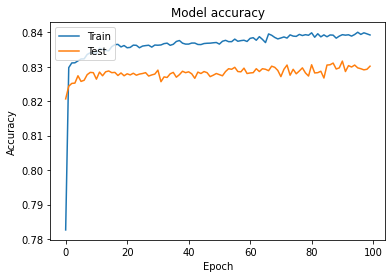

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

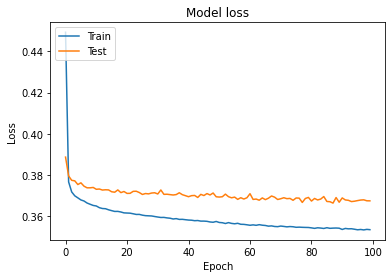

In [32]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Save trained models for use in prediction algorithms

In [33]:
from joblib import dump, load
dump(dec_tree, "decision_tree.pkl")
dump(model, "neural_net.pkl")
# dump(sc, "decision_tree_scaler.pkl")
dump(nnsc, "neural_net_scaler.pkl")

INFO:tensorflow:Assets written to: ram://12234844-128c-40f0-bfac-7e77872ee029/assets


['neural_net_scaler.pkl']